# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$ Nm.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
N = 40  # Horizon length.
RENDER = True  # Whether to render the environment or not.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = model.constrain(U).detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[0] = (final_state[0] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U, K = controller.fit(U, encoding=ENCODING, n_iterations=200,
                         on_iteration=on_iteration)

iteration 3 accepted 597.1236 [2.4706001 1.3970644]
iteration 4 accepted 588.165 [2.432649  1.3813239]
iteration 6 accepted 578.2248 [2.3350863 1.3892813]
iteration 8 accepted 286.35907 [1.7054992  0.24924767]
iteration 9 accepted 218.41046 [1.3353536  0.05520093]
iteration 10 accepted 142.14743 [ 0.7678905  -0.42844903]
iteration 11 accepted 109.8731 [ 0.70938337 -0.07910466]
iteration 12 accepted 86.40802 [ 0.5198188  -0.22706294]
iteration 13 accepted 64.131676 [0.3131151  0.03043091]
iteration 14 accepted 59.690693 [0.29060483 0.02122664]
iteration 15 accepted 55.761696 [ 0.24555475 -0.01746911]
iteration 16 accepted 52.27621 [ 0.17161225 -0.04727763]
iteration 17 accepted 50.430782 [ 0.0854886  -0.04908842]
iteration 18 accepted 49.66029 [ 0.08941926 -0.04759794]
iteration 19 accepted 48.682312 [ 0.0799264 -0.0479759]
iteration 20 accepted 48.253277 [ 0.08164635 -0.0390611 ]
iteration 21 accepted 47.549786 [ 0.06491674 -0.01047382]
iteration 22 accepted 47.242855 [ 0.06887172 -0.0

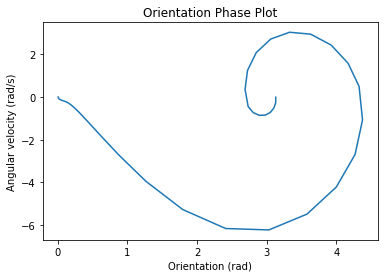

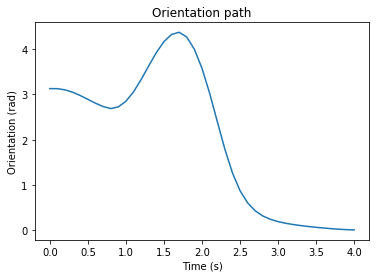

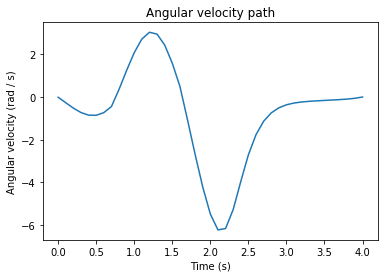

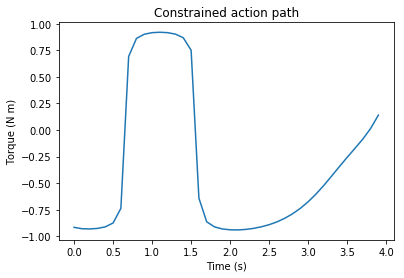

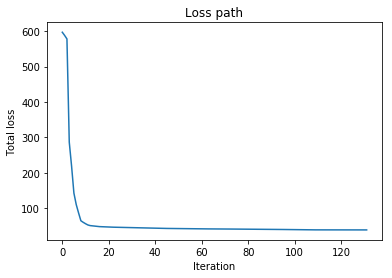

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()